In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns

from matplotlib.ticker import FormatStrFormatter
from sklearn.model_selection import cross_val_score

from itertools import product
from hpo_tune.experiments import get_generic_preprocessing_pipeline, get_model_pipeline
from hpo_tune.utils import _string_to_list, load_best_params

# Analysis

## Algorithm analisys

###  Baselines

In [2]:
baseline_result_df = pd.DataFrame(columns=["model", "data", "baseline_score"])

models = [
    "data/input/gradient-boosting.pkl",
    "data/input/logistic-regression.pkl",
    "data/input/svm.pkl"
]

datasets = [
    "data/input/credit-g.csv",
    "data/input/kr-vs-kp.csv",
    "data/input/qsar-biodeg.csv",
    "data/input/steel-plates-fault.csv"
]

for i, (model_path, dataset_path) in enumerate(product(models, datasets)):
    model_name = model_path.split("/")[-1].split(".")[0]
    dataset_name = dataset_path.split("/")[-1].split(".")[0]
    print(f"{model_name} - {dataset_name}")
    df = pd.read_csv(dataset_path)
    with open(model_path, "rb") as f:
        model_class = pkl.load(f)

    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    model = model_class(l1_ratio=0.5) if model_name == "logistic-regression" else model_class()
    preprocessing_pipeline = get_generic_preprocessing_pipeline()
    model_pipeline = get_model_pipeline(model, preprocessing_pipeline)
    
    score = cross_val_score(model_pipeline, X, y, cv=3).mean()
    baseline_result_df.loc[i] = [model_name, dataset_name, score]
baseline_result_df = baseline_result_df.replace("qsar-biodeg", "qsar-biodeq")
baseline_result_df = baseline_result_df.replace("svm", "svc")

gradient-boosting - credit-g
gradient-boosting - kr-vs-kp
gradient-boosting - qsar-biodeg
gradient-boosting - steel-plates-fault
logistic-regression - credit-g
logistic-regression - kr-vs-kp
logistic-regression - qsar-biodeg
logistic-regression - steel-plates-fault
svm - credit-g
svm - kr-vs-kp
svm - qsar-biodeg
svm - steel-plates-fault


### Algorithm convergence

In [3]:
results_random = pd.read_csv("data/output/results_random-11-09-2023-23:30:02.csv").drop(columns=["Unnamed: 0"])
results_random = results_random.merge(baseline_result_df, "inner", on=["data", "model"])
results_random["mean_score_history"] = results_random["mean_score_history"].apply(_string_to_list)

bayes_search_results = pd.read_csv("data/output/results_bayes-11-09-2023-23:30:02.csv").drop(columns=["Unnamed: 0"])
bayes_search_results = bayes_search_results.merge(baseline_result_df, "inner", on=["data", "model"])
bayes_search_results["mean_score_history"] = bayes_search_results["mean_score_history"].apply(_string_to_list)

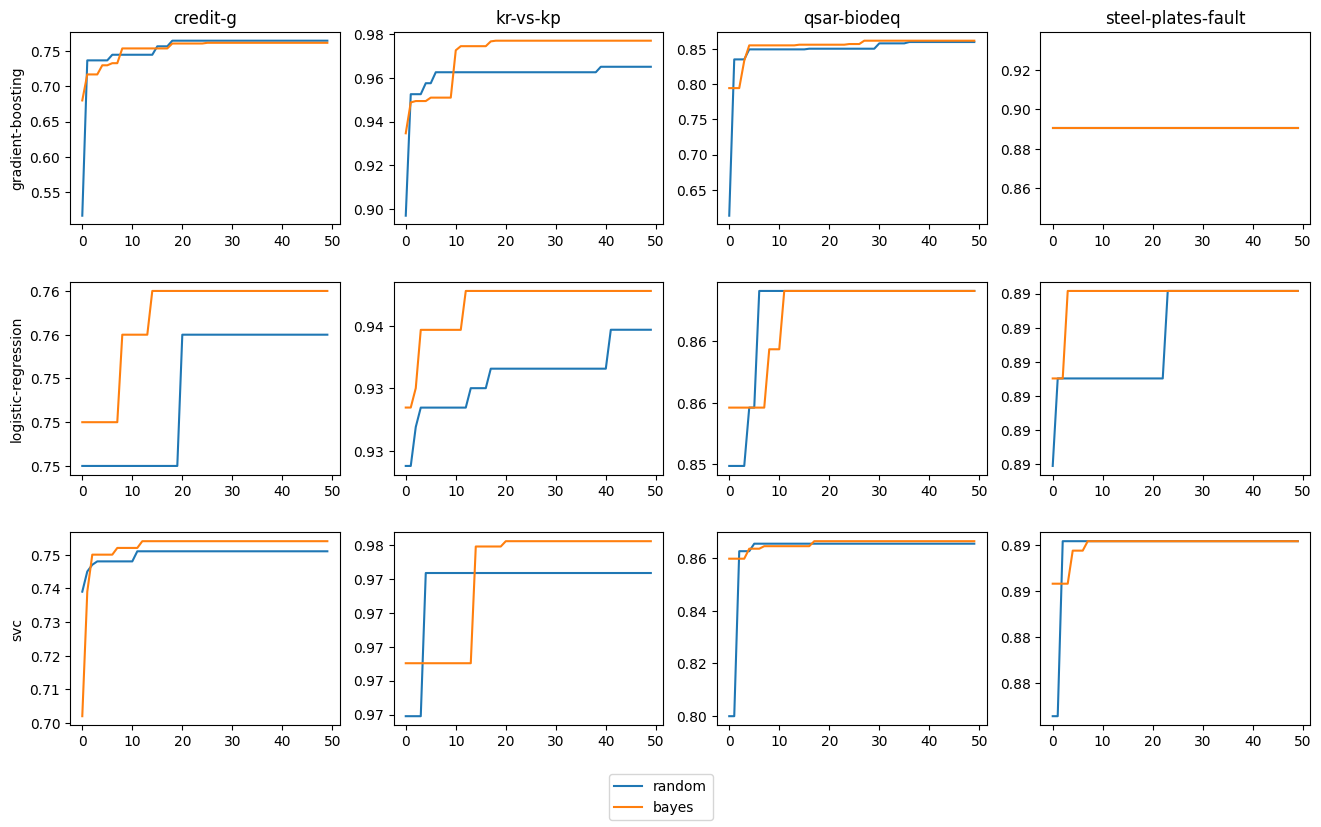

In [77]:
results_random = results_random.sort_values(["model", "data"]).reset_index(drop=True)
bayes_search_results = bayes_search_results.sort_values(["model", "data"]).reset_index(drop=True)

fig, ax = plt.subplots(3, 4, figsize=(16, 9))
for i, row in results_random.iterrows():
    history_random = np.maximum.accumulate(results_random.loc[i, "mean_score_history"])
    history_bayes = np.maximum.accumulate(bayes_search_results.loc[i, "mean_score_history"])
    
    ax[i//4, i%4].plot(history_random, label="random")
    ax[i//4, i%4].plot(history_bayes, label="bayes")
    
    if i == 0:
        ax[i//4, i%4].set_ylabel(row["model"])
        ax[i//4, i%4].set_title(row["data"])
    elif i//4 == 0:
        ax[i//4, i%4].set_title(row["data"])
    elif i%4 == 0:        
        ax[i//4, i%4].set_ylabel(row["model"])

    ax[i//4, i%4].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:2], labels[:2], loc='lower center')
fig.subplots_adjust(hspace = 0.3)

### Algorithm tunability - random search

In [5]:
gains = pd.DataFrame(columns=["model", "data", "gains"])
for i, row in results_random.iterrows():
    g = (np.array(row["mean_score_history"]).max() - row["baseline_score"])
    if g < 0: g = 0;
    gains.loc[i] = [row["model"], row["data"], max(0, g)]

[Text(0.5, 0, '')]

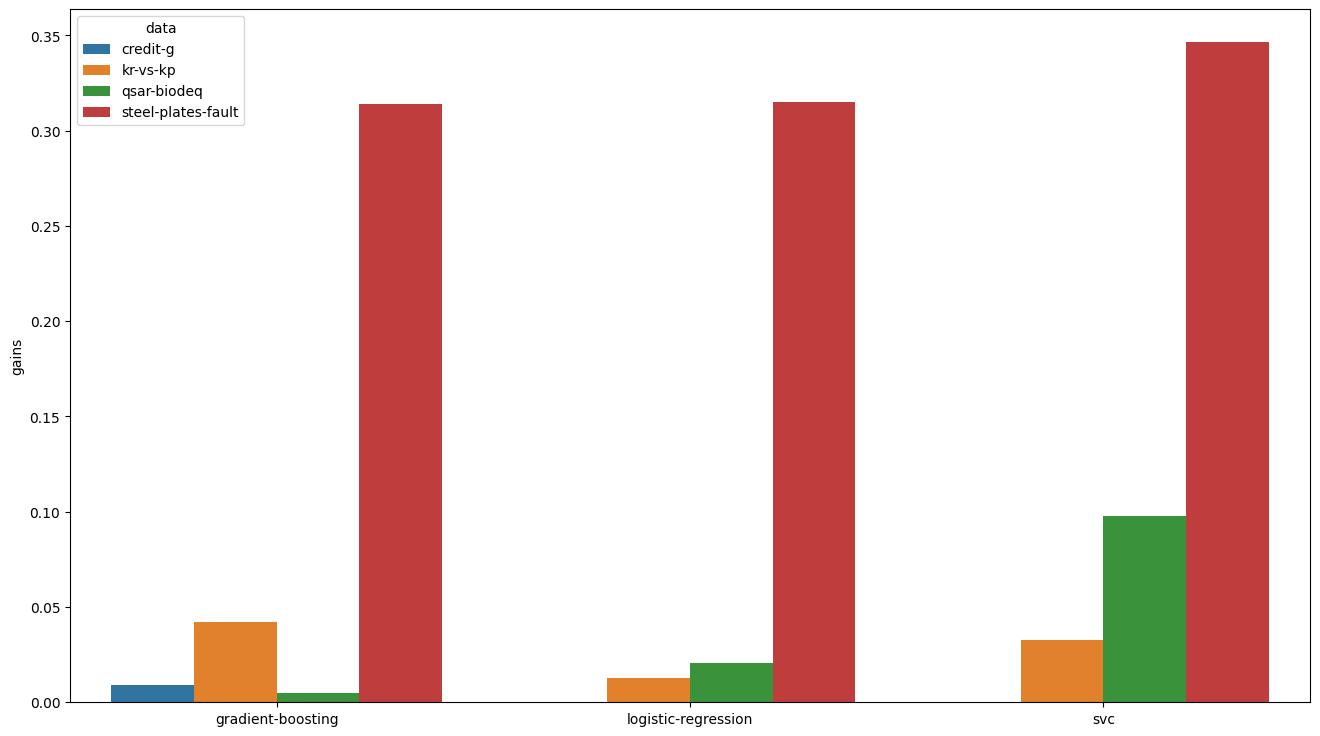

In [6]:
plt.figure(figsize=(16,9))
sns.barplot(gains, x="model", y="gains", hue="data").set(xlabel=None)

### Algorithm convergence - bayes search

In [7]:
bayes_search_results = pd.read_csv("data/output/results_bayes-11-09-2023-23:30:02.csv").drop(columns=["Unnamed: 0"])
bayes_search_results = bayes_search_results.merge(baseline_result_df, "inner", on=["data", "model"])
bayes_search_results["mean_score_history"] = bayes_search_results["mean_score_history"].apply(_string_to_list)

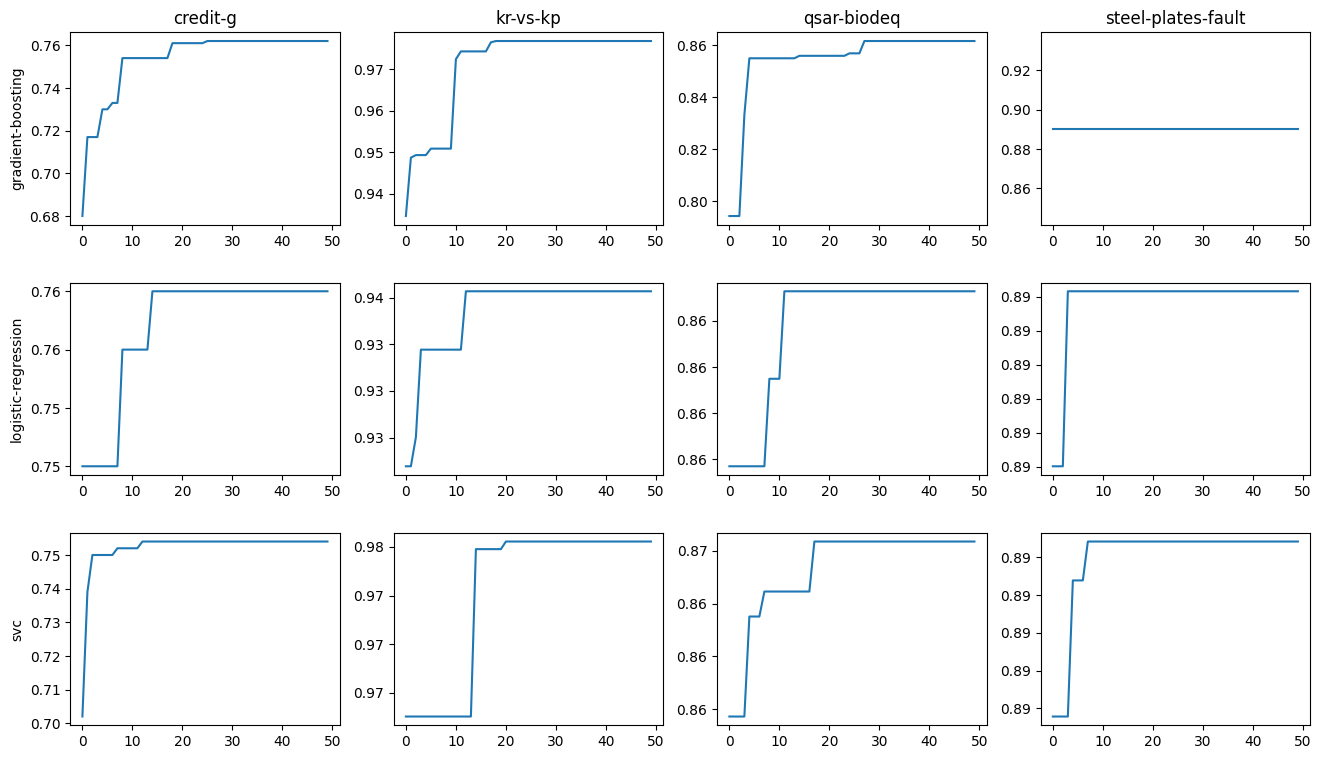

In [8]:
bayes_search_results = bayes_search_results.sort_values(["model", "data"]).reset_index(drop=True)

fig, ax = plt.subplots(3, 4, figsize=(16, 9))
for i, row in bayes_search_results.iterrows():
    story = row["mean_score_history"]
    story = np.maximum.accumulate(story)
    if i == 0:
        sns.lineplot(story, ax=ax[i//4, i%4]).set(title=row["data"], ylabel=row["model"])
    elif i//4 == 0:
        sns.lineplot(story, ax=ax[i//4, i%4]).set(title=row["data"])
    elif i%4 == 0:
        sns.lineplot(story, ax=ax[i//4, i%4]).set(ylabel=row["model"])
    else:
        sns.lineplot(story, ax=ax[i//4, i%4])
    ax[i//4, i%4].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

fig.subplots_adjust(hspace = 0.3)

### Algorithm tunability - bayes search

In [15]:
gains = pd.DataFrame(columns=["model", "data", "gains"])
for i, row in bayes_search_results.iterrows():
    g = (np.array(row["mean_score_history"]).max() - row["baseline_score"])
    if g < 0: g = 0;
    gains.loc[i] = [row["model"], row["data"], max(0, g)]

[Text(0, 0.5, 'accuracy gain'), Text(0.5, 0, '')]

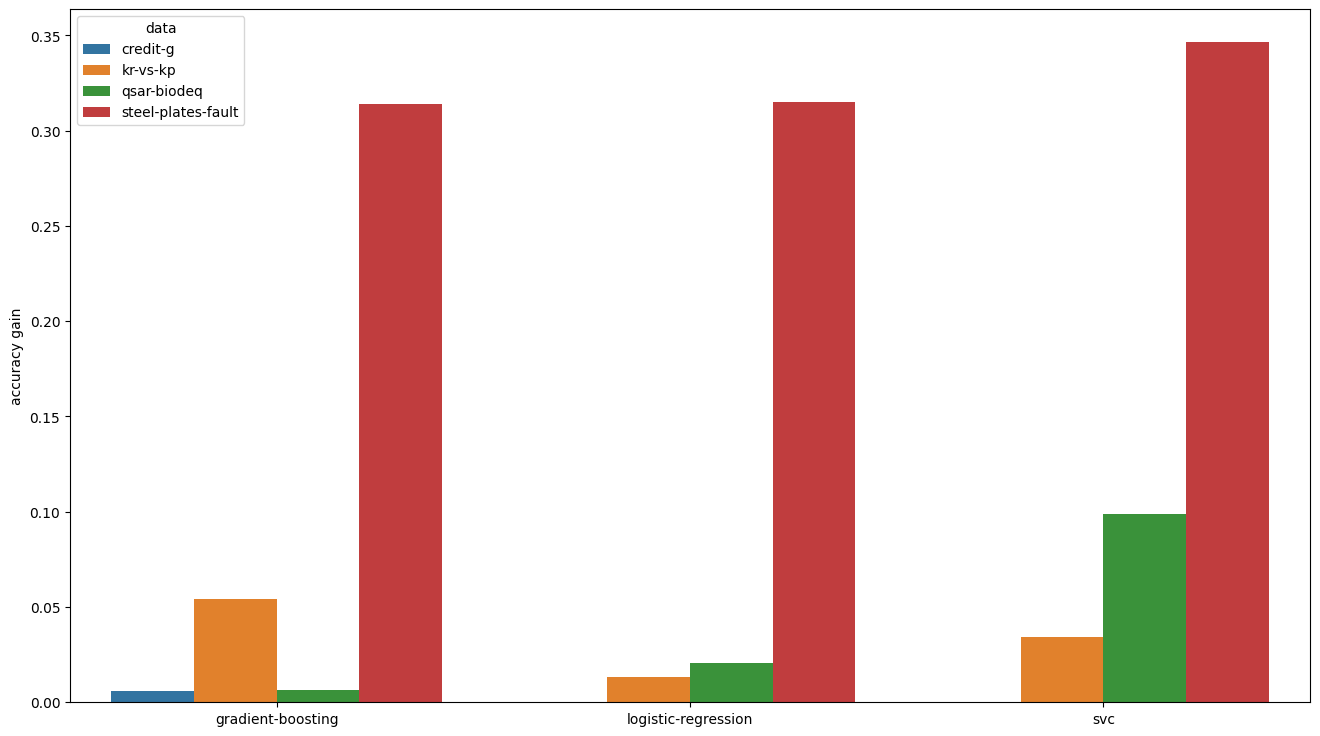

In [16]:
plt.figure(figsize=(16,9))
sns.barplot(gains, x="model", y="gains", hue="data").set(ylabel="accuracy gain", xlabel=None)

## Single param analisys - random search

In [11]:
results_single_random = pd.read_csv("data/output/results_single_random-11-09-2023-23:30:02.csv").drop(columns=["Unnamed: 0"])

single_param_baseline_results = pd.DataFrame(columns=["model", "data", "baseline_score"])
random_results_path = "data/output/results_random-11-09-2023-23:30:02.csv"

models = [
    "data/input/gradient-boosting.pkl",
    "data/input/logistic-regression.pkl",
    "data/input/svm.pkl"
]

datasets = [
    "data/input/credit-g.csv",
    "data/input/kr-vs-kp.csv",
    "data/input/qsar-biodeg.csv",
    "data/input/steel-plates-fault.csv"
]

for i, (model_path, dataset_path) in enumerate(product(models, datasets)):
    model_name = model_path.split("/")[-1].split(".")[0]
    dataset_name = dataset_path.split("/")[-1].split(".")[0]
    print(f"{model_name} - {dataset_name}")
    model_name = model_name if model_name != "svm" else "svc"
    params = load_best_params(model_name, random_results_path)
    df = pd.read_csv(dataset_path)
    with open(model_path, "rb") as f:
        model_class = pkl.load(f)

    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    
    model = model_class(**params)
    preprocessing_pipeline = get_generic_preprocessing_pipeline()
    model_pipeline = get_model_pipeline(model, preprocessing_pipeline)
    
    score = cross_val_score(model_pipeline, X, y, cv=3).mean()
    single_param_baseline_results.loc[i] = [model_name, dataset_name, score]
single_param_baseline_results = single_param_baseline_results.replace("qsar-biodeg", "qsar-biodeq")

results_single_random = results_single_random.merge(single_param_baseline_results, "inner", ["model", "data"])
results_single_random["accuracy gain"] = results_single_random["best_score"] - results_single_random["baseline_score"]
results_single_random.loc[results_single_random["accuracy gain"] < 0, "accuracy gain"] = 0
results_single_random["param"] = results_single_random["best_params"].apply(lambda x: list(json.loads(str.replace(x, "'", '"')).keys())[0])

gradient-boosting - credit-g
gradient-boosting - kr-vs-kp
gradient-boosting - qsar-biodeg
gradient-boosting - steel-plates-fault
logistic-regression - credit-g
logistic-regression - kr-vs-kp
logistic-regression - qsar-biodeg
logistic-regression - steel-plates-fault
svm - credit-g
svm - kr-vs-kp


/mnt/linux/sync/studies/automl/AutoML-2023Z-hw1/.venv/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


svm - qsar-biodeg
svm - steel-plates-fault


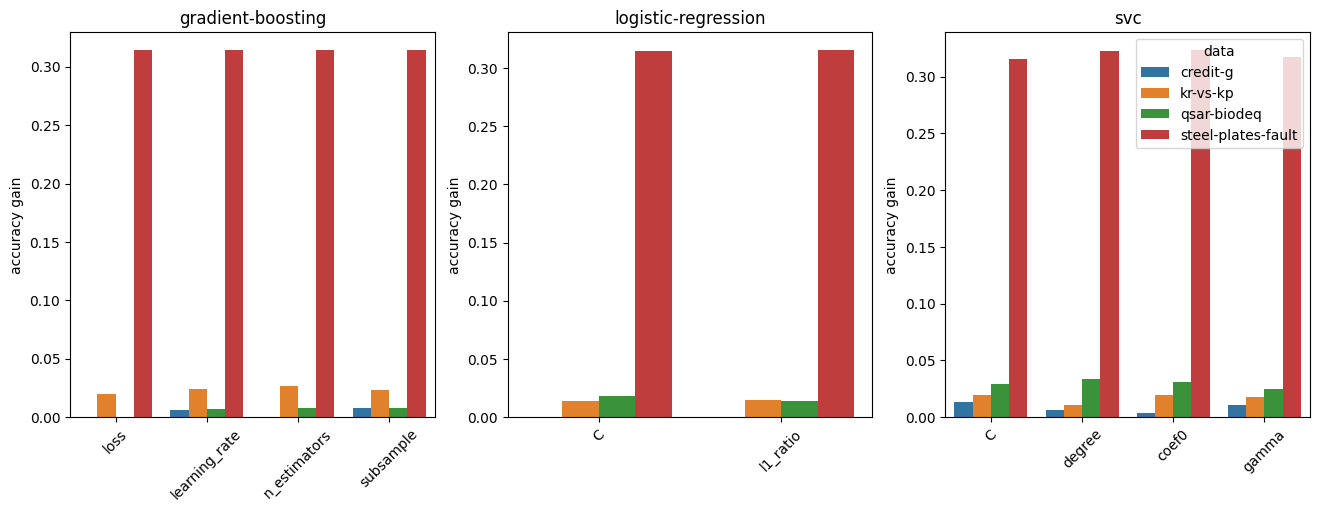

In [12]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(16,5))

for i, model_name in enumerate(["gradient-boosting", "logistic-regression", "svc"]):
    plt.xticks(rotation=45)
    sns.barplot(
        data=results_single_random.loc[results_single_random.model == model_name],
        x="param",
        y="accuracy gain",
        hue="data",
        ax=ax[i]
    ).set(xlabel=None)
    if i < 2:
        ax[i].legend([],[], frameon=False)
    ax[i].set(title=model_name)
    plt.setp( ax[i].xaxis.get_majorticklabels(), rotation=45)

## Single param analisys - bayes optimization

In [18]:
results_single_bayes = pd.read_csv("data/output/results_signle_bayes-11-09-2023-23:30:02.csv").drop(columns=["Unnamed: 0"])

single_param_baseline_results = pd.DataFrame(columns=["model", "data", "baseline_score"])
random_results_path = "data/output/results_random-11-09-2023-23:30:02.csv"

models = [
    "data/input/gradient-boosting.pkl",
    "data/input/logistic-regression.pkl",
    "data/input/svm.pkl"
]

datasets = [
    "data/input/credit-g.csv",
    "data/input/kr-vs-kp.csv",
    "data/input/qsar-biodeg.csv",
    "data/input/steel-plates-fault.csv"
]

for i, (model_path, dataset_path) in enumerate(product(models, datasets)):
    model_name = model_path.split("/")[-1].split(".")[0]
    dataset_name = dataset_path.split("/")[-1].split(".")[0]
    print(f"{model_name} - {dataset_name}")
    model_name = model_name if model_name != "svm" else "svc"
    params = load_best_params(model_name, random_results_path)
    df = pd.read_csv(dataset_path)
    with open(model_path, "rb") as f:
        model_class = pkl.load(f)

    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    
    model = model_class(**params)
    preprocessing_pipeline = get_generic_preprocessing_pipeline()
    model_pipeline = get_model_pipeline(model, preprocessing_pipeline)
    
    score = cross_val_score(model_pipeline, X, y, cv=3).mean()
    single_param_baseline_results.loc[i] = [model_name, dataset_name, score]
single_param_baseline_results = single_param_baseline_results.replace("qsar-biodeg", "qsar-biodeq")

results_single_bayes = results_single_bayes.merge(single_param_baseline_results, "inner", ["model", "data"])
results_single_bayes["accuracy gain"] = results_single_bayes["best_score"] - results_single_random["baseline_score"]
results_single_bayes.loc[results_single_bayes["accuracy gain"] < 0, "accuracy gain"] = 0
results_single_bayes["param"] = results_single_bayes["best_params"].apply(lambda x: list(json.loads(str.replace(x, "'", '"')).keys())[0])

gradient-boosting - credit-g
gradient-boosting - kr-vs-kp
gradient-boosting - qsar-biodeg
gradient-boosting - steel-plates-fault
logistic-regression - credit-g
logistic-regression - kr-vs-kp
logistic-regression - qsar-biodeg
logistic-regression - steel-plates-fault
svm - credit-g
svm - kr-vs-kp


/mnt/linux/sync/studies/automl/AutoML-2023Z-hw1/.venv/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


svm - qsar-biodeg
svm - steel-plates-fault


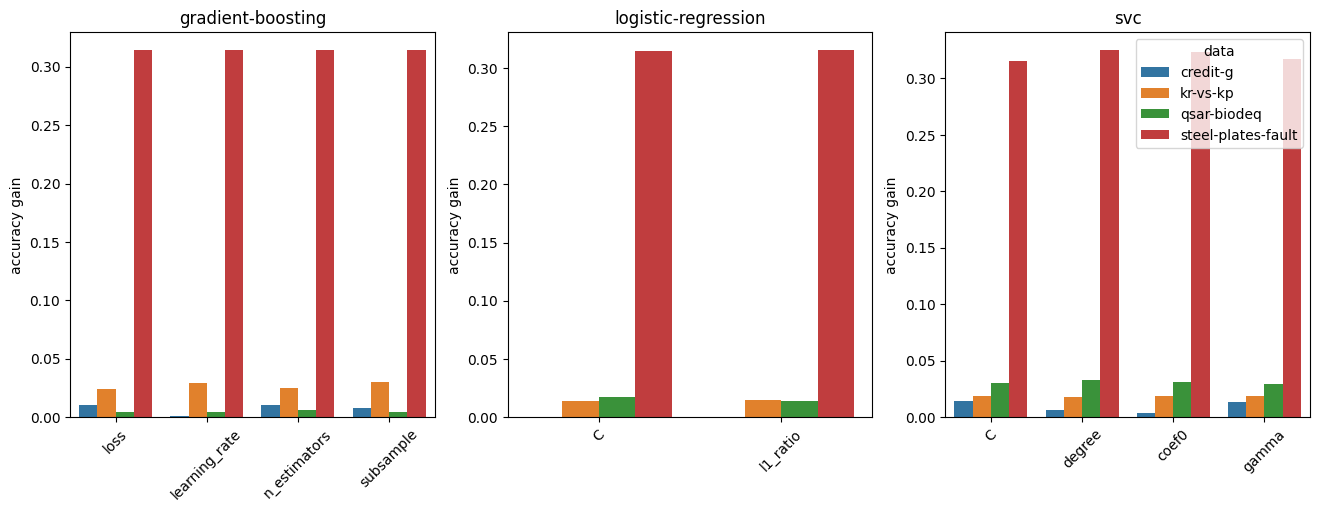

In [19]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(16,5))

for i, model_name in enumerate(["gradient-boosting", "logistic-regression", "svc"]):
    plt.xticks(rotation=45)
    sns.barplot(
        data=results_single_bayes.loc[results_single_bayes.model == model_name],
        x="param",
        y="accuracy gain",
        hue="data",
        ax=ax[i]
    ).set(xlabel=None)
    if i < 2:
        ax[i].legend([],[], frameon=False)
    ax[i].set(title=model_name)
    plt.setp( ax[i].xaxis.get_majorticklabels(), rotation=45)